In [1]:
import pandas as pd
import os
import sys
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import gc
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import catboost as cb
import lightgbm as lgb


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
pd.set_option('display.max_columns', None)
#CUDA понадобится в catboost

In [15]:
!pip install fastparquet


   ---------------------------------------- 0.0/672.0 kB ? eta -:--:--
    --------------------------------------- 10.2/672.0 kB ? eta -:--:--
   - ------------------------------------- 30.7/672.0 kB 435.7 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/672.0 kB 393.8 kB/s eta 0:00:02
   ----- --------------------------------- 92.2/672.0 kB 655.4 kB/s eta 0:00:01
   --------- ---------------------------- 163.8/672.0 kB 817.0 kB/s eta 0:00:01
   ------------ ------------------------- 225.3/672.0 kB 981.9 kB/s eta 0:00:01
   --------------------- ------------------ 368.6/672.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------- ----------- 471.0/672.0 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 672.0/672.0 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.6 MB 15.7 MB/s eta 0:00:01
   ----- ---------------------------------- 0.2/1.6 MB 15.7 MB/s eta 0:

In [3]:
cuda_path = 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4'
os.environ['CUDA_HOME'] = cuda_path
os.environ['PATH'] = cuda_path + ';' + os.environ['PATH']
os.environ['PATH'] = os.path.join(cuda_path, 'bin') + ';' + os.environ['PATH']
os.environ['PATH'] = os.path.join(cuda_path, 'libnvvp') + ';' + os.environ['PATH']

# Указываем, какой GPU использовать
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Проверка в PyTorch
import torch
print("CUDA is available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CuDNN version:", torch.backends.cudnn.version())

CUDA is available: True
CUDA version: 11.8
CuDNN version: 8700


In [2]:
import warnings 
warnings.filterwarnings('ignore')

# Модель кредитного риск-менеджмента

## Loadig/Analyzing Data

In [3]:
df_target = pd.read_csv('data/train_target.csv')
df_target.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [4]:
df_target.shape

(3000000, 2)

In [12]:
df_target['flag'].value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

In [5]:
from data_partition_loader import read_parquet_dataset_from_local

In [9]:
path = "data/train_data"
#прочитаем одну партицию в память и оценим, сколько RAM занимает весь DataFrame
data = read_parquet_dataset_from_local(path_to_dataset=path, num_parts_to_read=1)

mdemory_usage_of_data = data.memory_usage(index=True).sum() / 10 ** 9
expected_memory_usage = mdemory_usage_of_data * 12
print(f"Объем памяти в RAM одной партиции данных с кредитными историями: {round(mdemory_usage_of_data, 3)} GB")
print(f"Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} GB")

Чтение набора данных с pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Объем памяти в RAM одной партиции данных с кредитными историями: 0.964 GB
Ожидаемый размер в RAM всего датасета: 11.564 GB


In [10]:
del data
gc.collect()

1489

In [11]:
from data_partition_loader import prepare_transactions_dataset, read_parquet_dataset_from_local

In [12]:
data = prepare_transactions_dataset(path_to_dataset=path, num_parts_to_preprocess_at_once=4, num_parts_total=12,
                                    save_to_path='data/train_data/')
data

Transforming transactions data:   0%|          | 0/3 [00:00<?, ?it/s]

Чтение набора данных с pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Чтение набора данных с pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Чтение набора данных с pandas:   0%|          | 0/4 [00:00<?, ?it/s]

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  \
0              0   1                18                    9          2   
1              0   2                18                    9         14   
2              0   3                18                    9          4   
3              0   4                 4                    1          9   
4              0   5                 5                   12         15   
...          ...  ..               ...                  ...        ...   
9273868  2999999   8                 6                    5         14   
9273869  2999999   9                 5                    3          2   
9273870  2999999  10                 3                   16         11   
9273871  2999999  11                 3                    6          4   
9273872  2999999  12                 2                    2          2   

         pre_fterm  pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0                3               16               10                      11   
1               14               12               12                       0   
2                8                1               11                      11   
3               12               16                7                      12   
4                2               11               12                      10   
...            ...              ...              ...                     ...   
9273868         13                1               15                      16   
9273869         10               15               14                      17   
9273870         13               14                8                      15   
9273871          8                1               11                       0   
9273872         14               12               11                      10   

         pre_loans_next_pay_summ  pre_loans_outstanding  \
0                              3                      3   
1                              3                      3   
2                              0                      5   
3                              2                      3   
4                              2                      3   
...                          ...                    ...   
9273868                        2                      3   
9273869                        2                      3   
9273870                        5                      1   
9273871                        5                      1   
9273872                        1                      4   

         pre_loans_total_overdue  pre_loans_max_overdue_sum  \
0                              0                          2   
1                              0                          2   
2                              0                          2   
3                              0                          2   
4                              0                          2   
...                          ...                        ...   
9273868                        0                          2   
9273869                        0                          2   
9273870                        0                          2   
9273871                        0                          2   
9273872                        0                          2   

         pre_loans_credit_cost_rate  pre_loans5  pre_loans530  pre_loans3060  \
0                                11           6            16              5   
1                                11           6            16              5   
2                                 8           6            16              5   
3                                 4           6            16              5   
4                                 4           6            16              5   
...                             ...         ...           ...            ...   
9273868                           0           6            16              5   
9273869                          13           6           

In [15]:
data = data.drop_duplicates(subset='id')

In [ ]:
data = df_target.merge(data, on='id')
data.isna().sum().sum()

In [60]:
data.head()

id  flag  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0     0   1                18                    9          2          3   
1   1     0   1                 8                    7         12         15   
2   2     0   1                 0                    9          4          8   
3   3     0   1                13                   14          9          0   
4   4     0   1                12                    9          4          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1                9                1                       1   
2                1               11                       1   
3               13                5                      13   
4                1               11                      12   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        2                      4                        0   
2                        1                      2                        0   
3                        2                      3                        0   
4                        1                      3                        0   

   pre_loans_max_overdue_sum  pre_loans_credit_cost_rate  pre_loans5  \
0                          2                          11           6   
1                          1                           4           6   
2                          1                           3           6   
3                          2                           4           6   
4                          2                           0           6   

   pre_loans530  pre_loans3060  pre_loans6090  pre_loans90  is_zero_loans5  \
0            16              5              4            8               1   
1            16              5              4            8               1   
2             2              5              4            8               1   
3            16              5              4            8               1   
4            16              5              4            8               1   

   is_zero_loans530  is_zero_loans3060  is_zero_loans6090  is_zero_loans90  \
0                 1                  1                  1                1   
1                 1                  0                  0                0   
2                 0                  0                  0                1   
3                 1                  1                  1                1   
4                 1                  1                  1                1   

   pre_util  pre_over2limit  pre_maxover2limit  is_zero_util  \
0        16               2                 17             1   
1         2              10                  8             0   
2         6               2                 11             0   
3        16               2                 17             1   
4        16               2                 17             1   

   is_zero_over2limit  is_zero_maxover2limit  enc_paym_0  enc_paym_1  \
0                   1                      1           0           0   
1                   0                      0           0           3   
2                   1                      0           0           0   
3                   1                      1           0           0   
4                   1                      1           3           3   

   enc_paym_2  enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  \
0           3           3           3           3           3           3   
1           3           3           3           3           3           3   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           3           3           3           3           3           3   

   enc_paym_8  enc_pay

In [22]:
!pip install --upgrade seaborn

  Using cached matplotlib-3.9.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 487.6 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/294.9 kB 744.7 kB/s eta 0:00:01
   ----------------------- ---------------- 174.1/294.9 kB 1.2 MB/s eta 0:00:01
   ------------------------------- -------- 235.5/294.9 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.2 MB/s eta 0:00:00
Using cached matplotlib-3.9.0-cp311-cp311-win_amd64.whl (8.0 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'C:\\Users\\USER\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.



In [31]:
!pip install --upgrade seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.9.0-cp311-cp311-win_amd64.whl.metadata (11 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.9.0-cp311-cp311-win_amd64.whl (8.0 MB)


ERROR: Could not install packages due to an OSError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'C:\\Users\\USER\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.



## Data Visualization

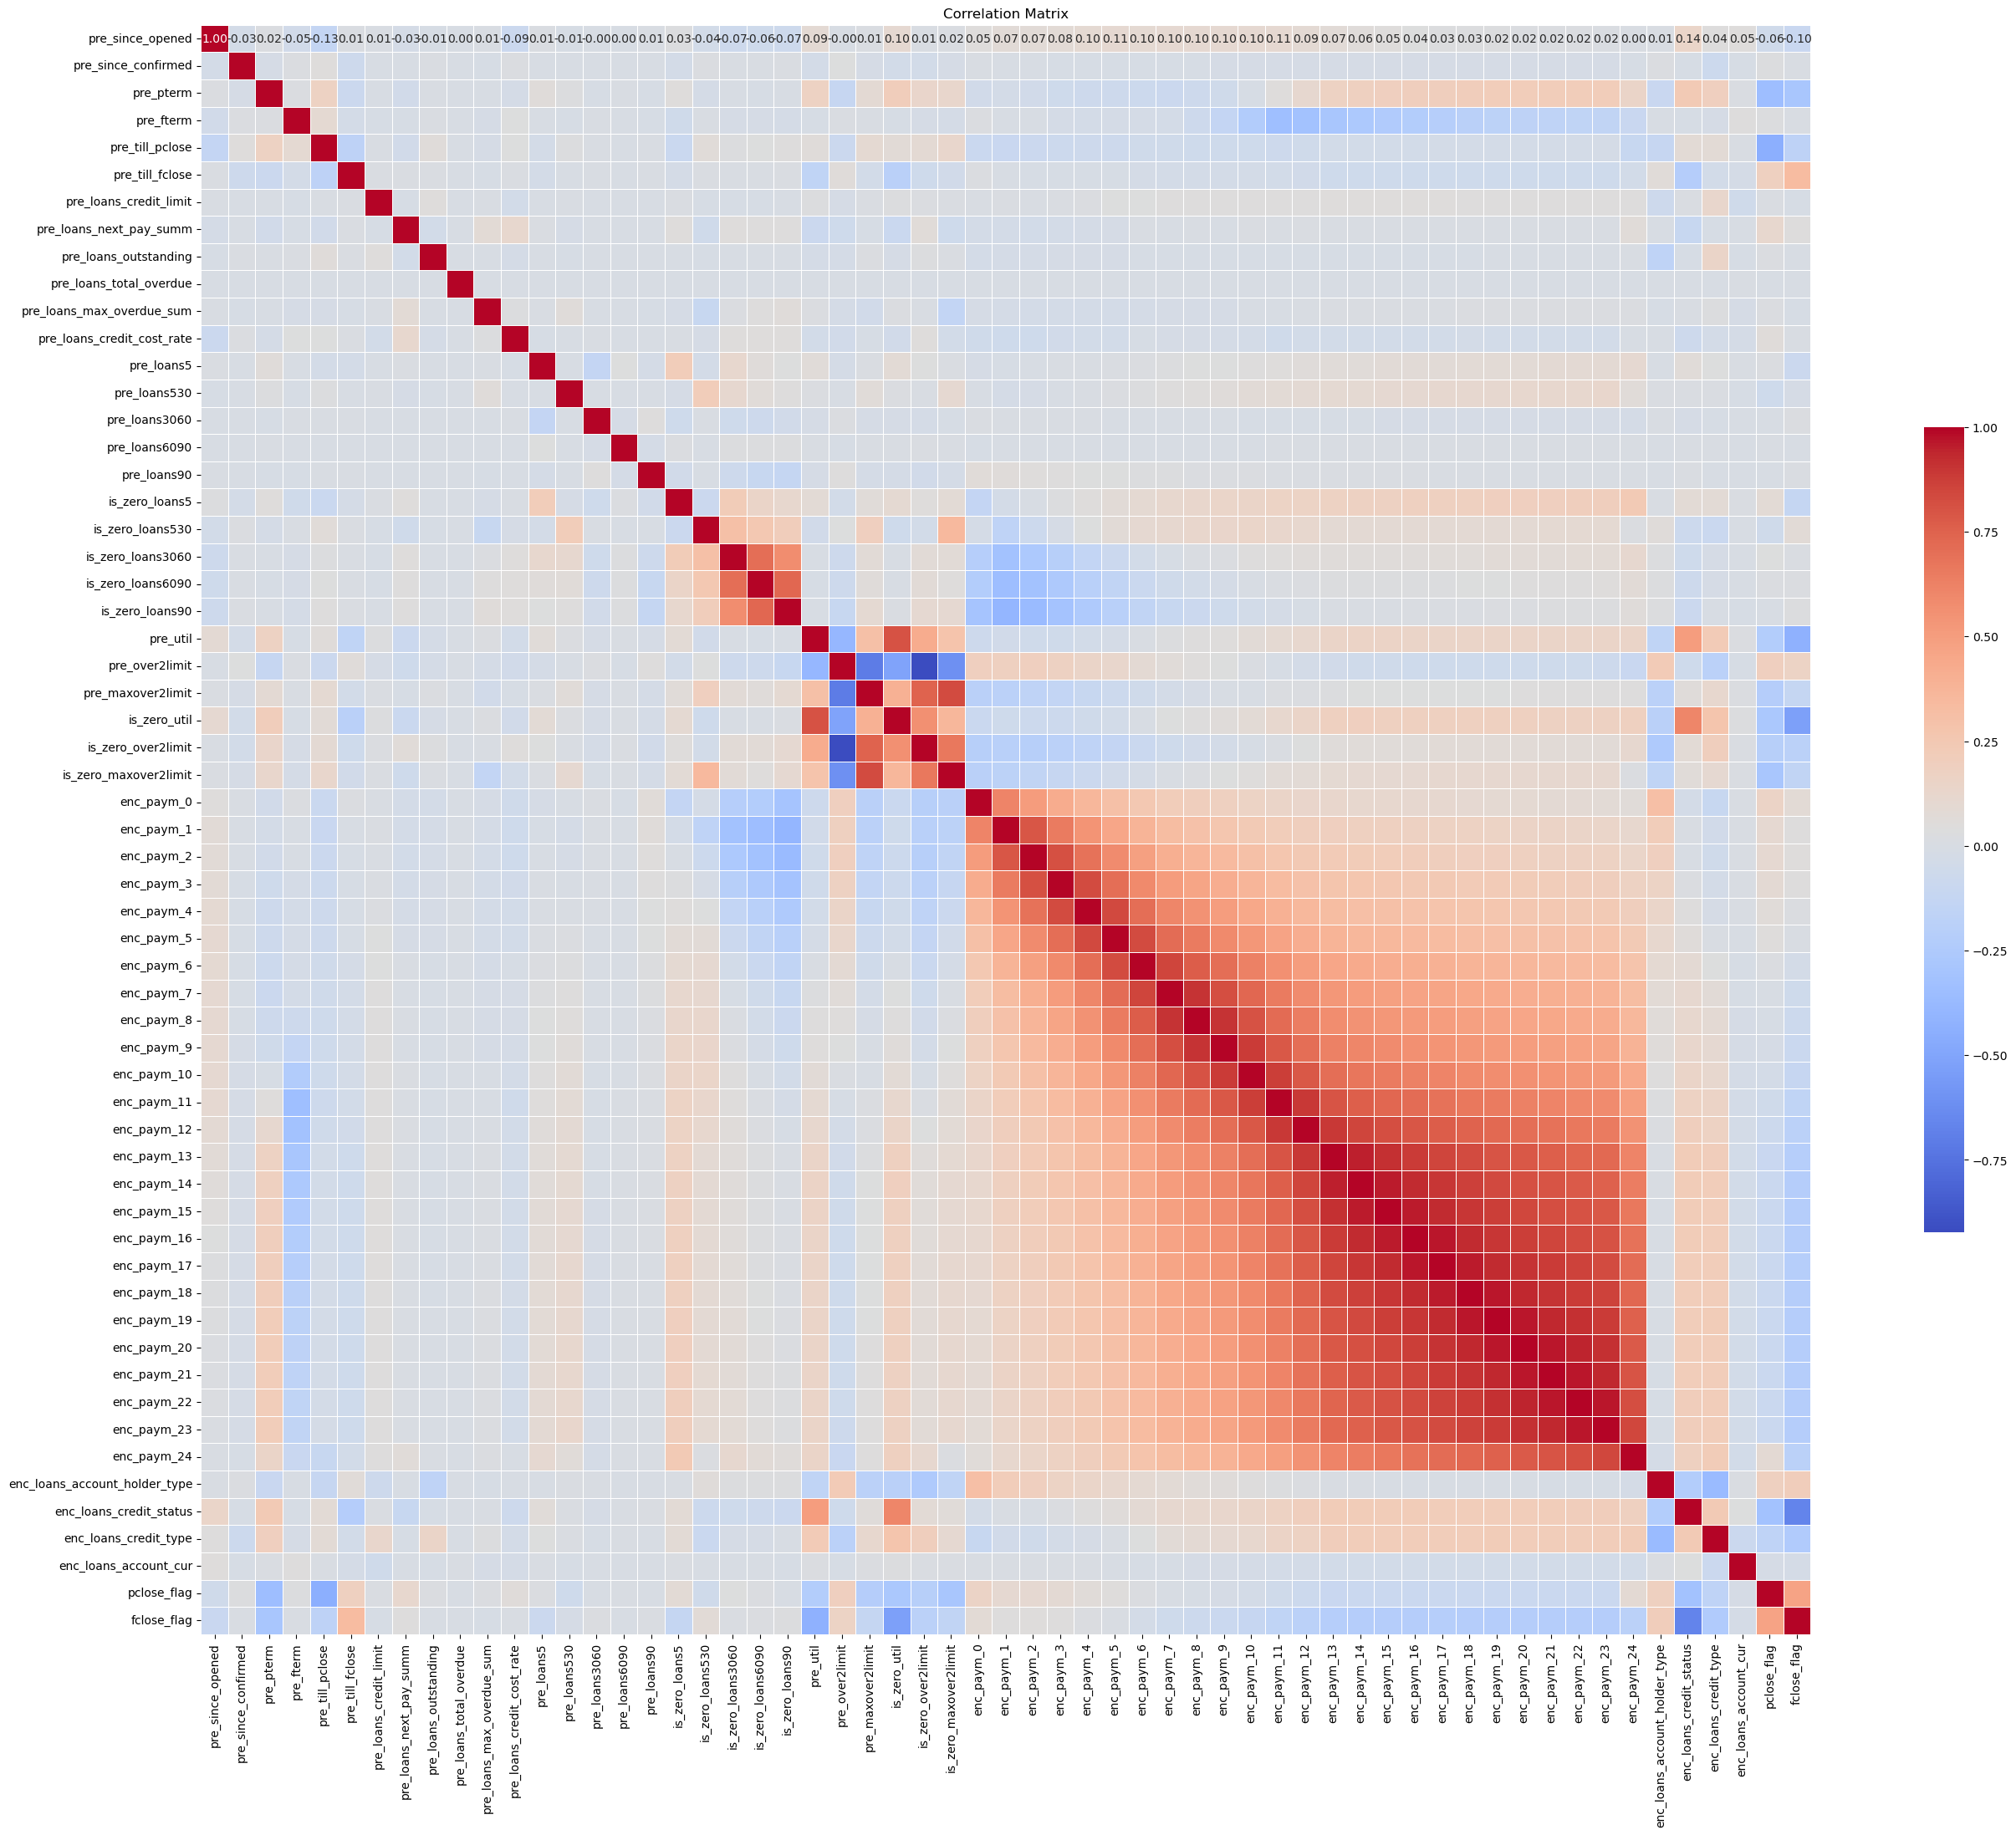

In [32]:
corr_matrix = data.drop(columns=['id', 'rn', 'flag']).corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(35, 25))  # Увеличиваем размер изображения
heatmap = sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                      square=True, linewidths=.5, cbar_kws={'shrink': .5}, 
                      annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

### Анализ матрицы:

Выделение сильных корреляций:

Сильные положительные корреляции (темно-красные ячейки):

Видно несколько групп признаков с высокой корреляцией, таких как pre_loans5, pre_loans530, pre_loans3060, pre_loans6090, pre_loans90 и их бинарные версии is_zero_loans_*.
Другие признаки, связанные с суммами задолженностей, также коррелируют друг с другом: pre_loans_total_overdue, pre_loans_max_overdue_sum, pre_over2limit, pre_maxover2limit.
Сильные отрицательные корреляции (темно-синие ячейки):

Несколько признаков имеют значительные отрицательные корреляции, например, is_zero_* признаки по отношению к суммам задолженностей.

Определяем порог коррелияции, выше 0.8
Например:
pre_loans5 и pre_loans530: можно оставить только один из них.
pre_loans_total_overdue и pre_loans_max_overdue_sum: можно оставить только один из них.
Признаки is_zero_* также можно проанализировать на предмет избыточности и оставить наиболее значимые.

In [40]:
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

corr_threshold = 0.6
# Найти признаки с сильной корреляцией
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]

# Удалить сильно коррелированные признаки из DataFrame
data_reduced = data.drop(to_drop, axis=1)

print(f"Удалены следующие признаки: {to_drop}")
print(f"Новая размерность данных: {data_reduced.shape}")

Удалены следующие признаки: ['is_zero_loans6090', 'is_zero_loans90', 'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_credit_status']
Новая размерность данных: (3000000, 32)


In [41]:
corr_matrix_reduced = data_reduced.corr()

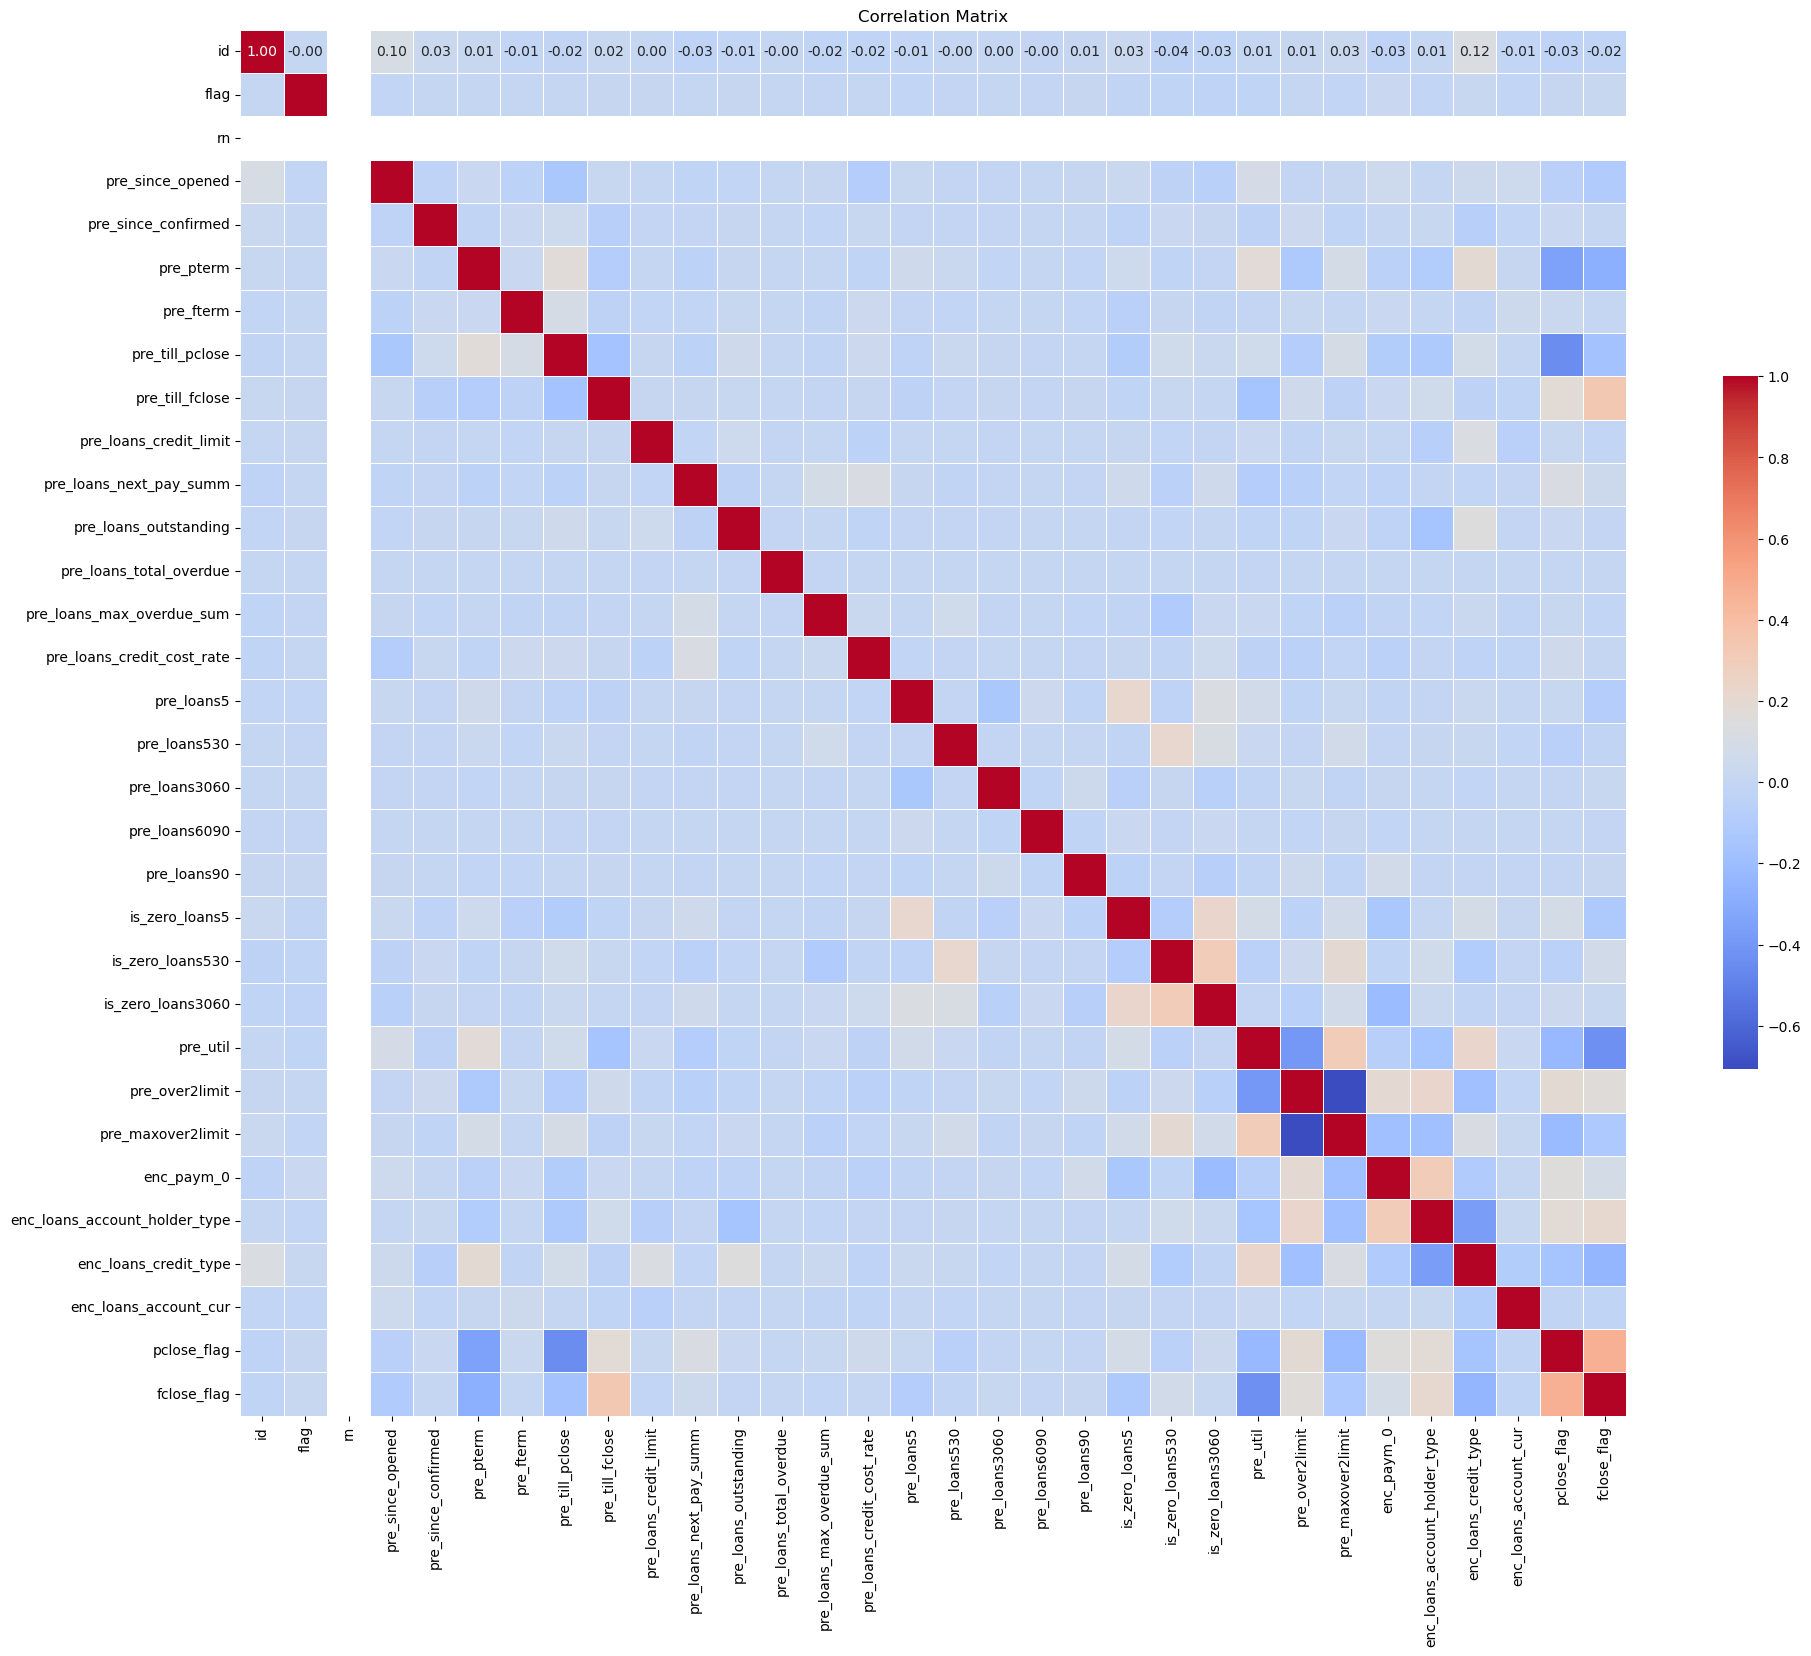

In [45]:
plt.figure(figsize=(25, 18))
heatmap = sns.heatmap(corr_matrix_reduced, annot=True, fmt='.2f', cmap='coolwarm', 
                      square=True, linewidths=.5, cbar_kws={'shrink': .5}, 
                      annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()

Псоле удаление сильно коррелирующих признаков, получилась такая матрица, но как выяснялось, когда я обучал первые модели, на результат это никак не влияло, поэтому в Baseline.ipynb я не удалял эти признаки 

In [47]:
data.head()

id  flag  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0     0   1                18                    9          2          3   
1   1     0   1                 8                    7         12         15   
2   2     0   1                 0                    9          4          8   
3   3     0   1                13                   14          9          0   
4   4     0   1                12                    9          4          8   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1                9                1                       1   
2                1               11                       1   
3               13                5                      13   
4                1               11                      12   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        2                      4                        0   
2                        1                      2                        0   
3                        2                      3                        0   
4                        1                      3                        0   

   pre_loans_max_overdue_sum  pre_loans_credit_cost_rate  pre_loans5  \
0                          2                          11           6   
1                          1                           4           6   
2                          1                           3           6   
3                          2                           4           6   
4                          2                           0           6   

   pre_loans530  pre_loans3060  pre_loans6090  pre_loans90  is_zero_loans5  \
0            16              5              4            8               1   
1            16              5              4            8               1   
2             2              5              4            8               1   
3            16              5              4            8               1   
4            16              5              4            8               1   

   is_zero_loans530  is_zero_loans3060  is_zero_loans6090  is_zero_loans90  \
0                 1                  1                  1                1   
1                 1                  0                  0                0   
2                 0                  0                  0                1   
3                 1                  1                  1                1   
4                 1                  1                  1                1   

   pre_util  pre_over2limit  pre_maxover2limit  is_zero_util  \
0        16               2                 17             1   
1         2              10                  8             0   
2         6               2                 11             0   
3        16               2                 17             1   
4        16               2                 17             1   

   is_zero_over2limit  is_zero_maxover2limit  enc_paym_0  enc_paym_1  \
0                   1                      1           0           0   
1                   0                      0           0           3   
2                   1                      0           0           0   
3                   1                      1           0           0   
4                   1                      1           3           3   

   enc_paym_2  enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  \
0           3           3           3           3           3           3   
1           3           3           3           3           3           3   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           3           3           3           3           3           3   

   enc_paym_8  enc_pay

In [49]:
del data_reduced
gc.collect()

<function gc.collect(generation=2)>

In [57]:
data_features = data.drop(columns=['id', 'rn', 'flag'])

In [64]:
data.to_csv('data_without_duplicates.csv', index=False)

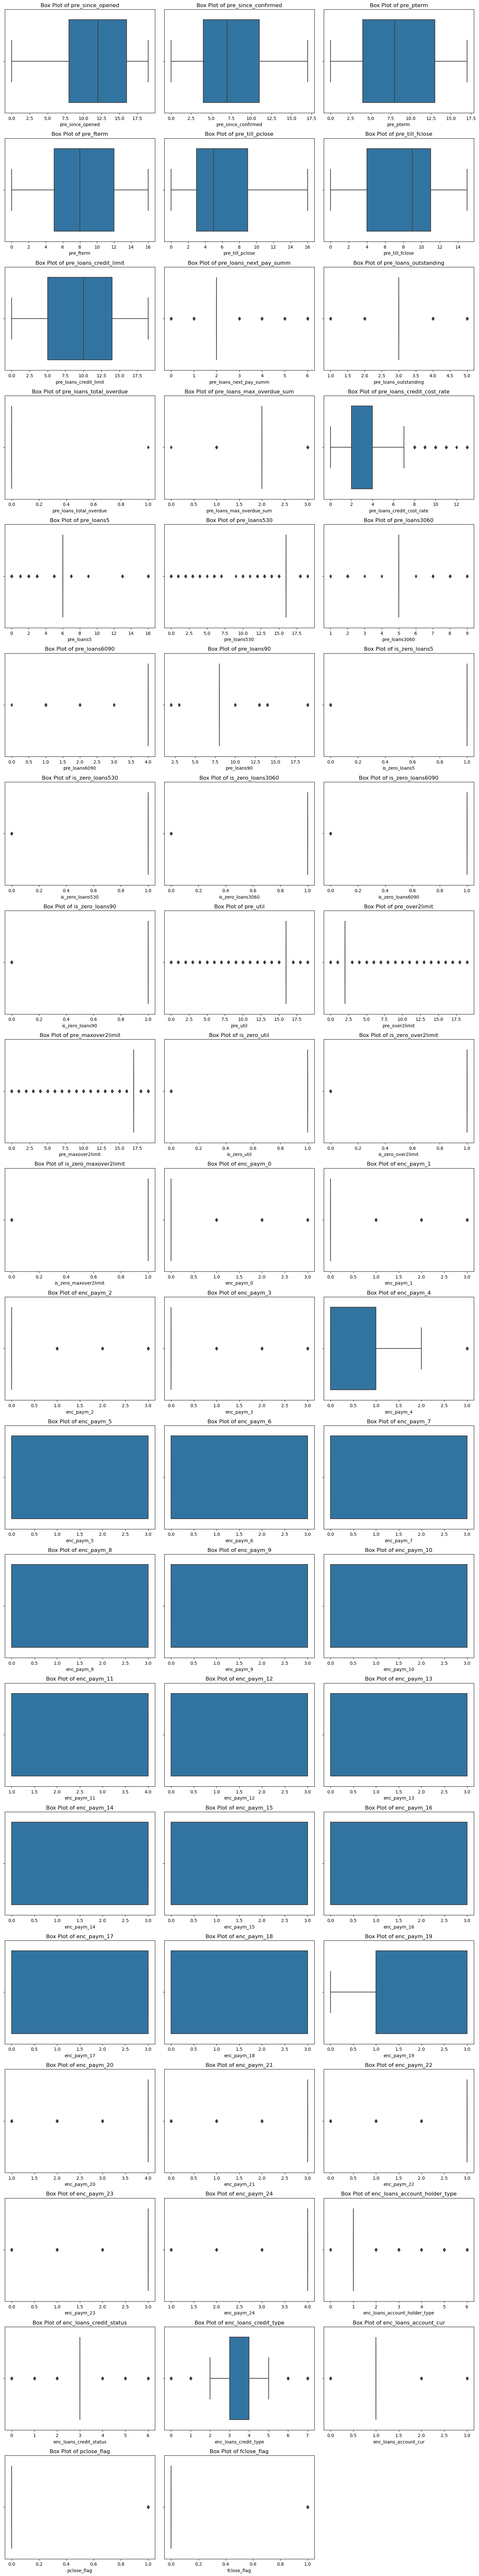

In [58]:

features = data_features.columns.tolist()

# Размеры сетки для отображения графиков
n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

# Создание фигуры для отображения графиков
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=data_features[feature])
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

Выбросы:
Признаки pre_loans_max_overdue_sum, pre_loans_credit_cost_rate, pre_loans5, pre_loans50, pre_loans60, pre_loans90, is_zero_loans360, is_zero_loans60, is_zero_loans90 и многие другие показывают точки за пределами усов, что указывает на наличие выбросов.
Эти выбросы могут быть значимыми для анализа, поскольку они могут представлять редкие, но важные случаи в данных.
Сравнение распределений:
Много признаков имеют различные распределения. признаки, такие как pre_loans_credit_limit, pre_loans_outstanding, и pre_loans_total_overdue имеют более широкие коробки, что указывает на более разнообразное распределение данных.
Напротив, такие признаки, как is_zero_unit, is_zero_over2limit, is_zero_maxover2limit, и другие показывают более сжатые распределения с меньшим количеством выбросов.

Некоторые признаки, такие как pre_loans_pay_summ, показывают смещение в одну сторону (например, положительное или отрицательное смещение), что видно по положению медианы внутри коробки.
Признаки, такие как enc_paym_2 и enc_paym_8, имеют сильное смещение, так как медиана находится ближе к одной из сторон коробки, и имеются выбросы только с одной стороны.

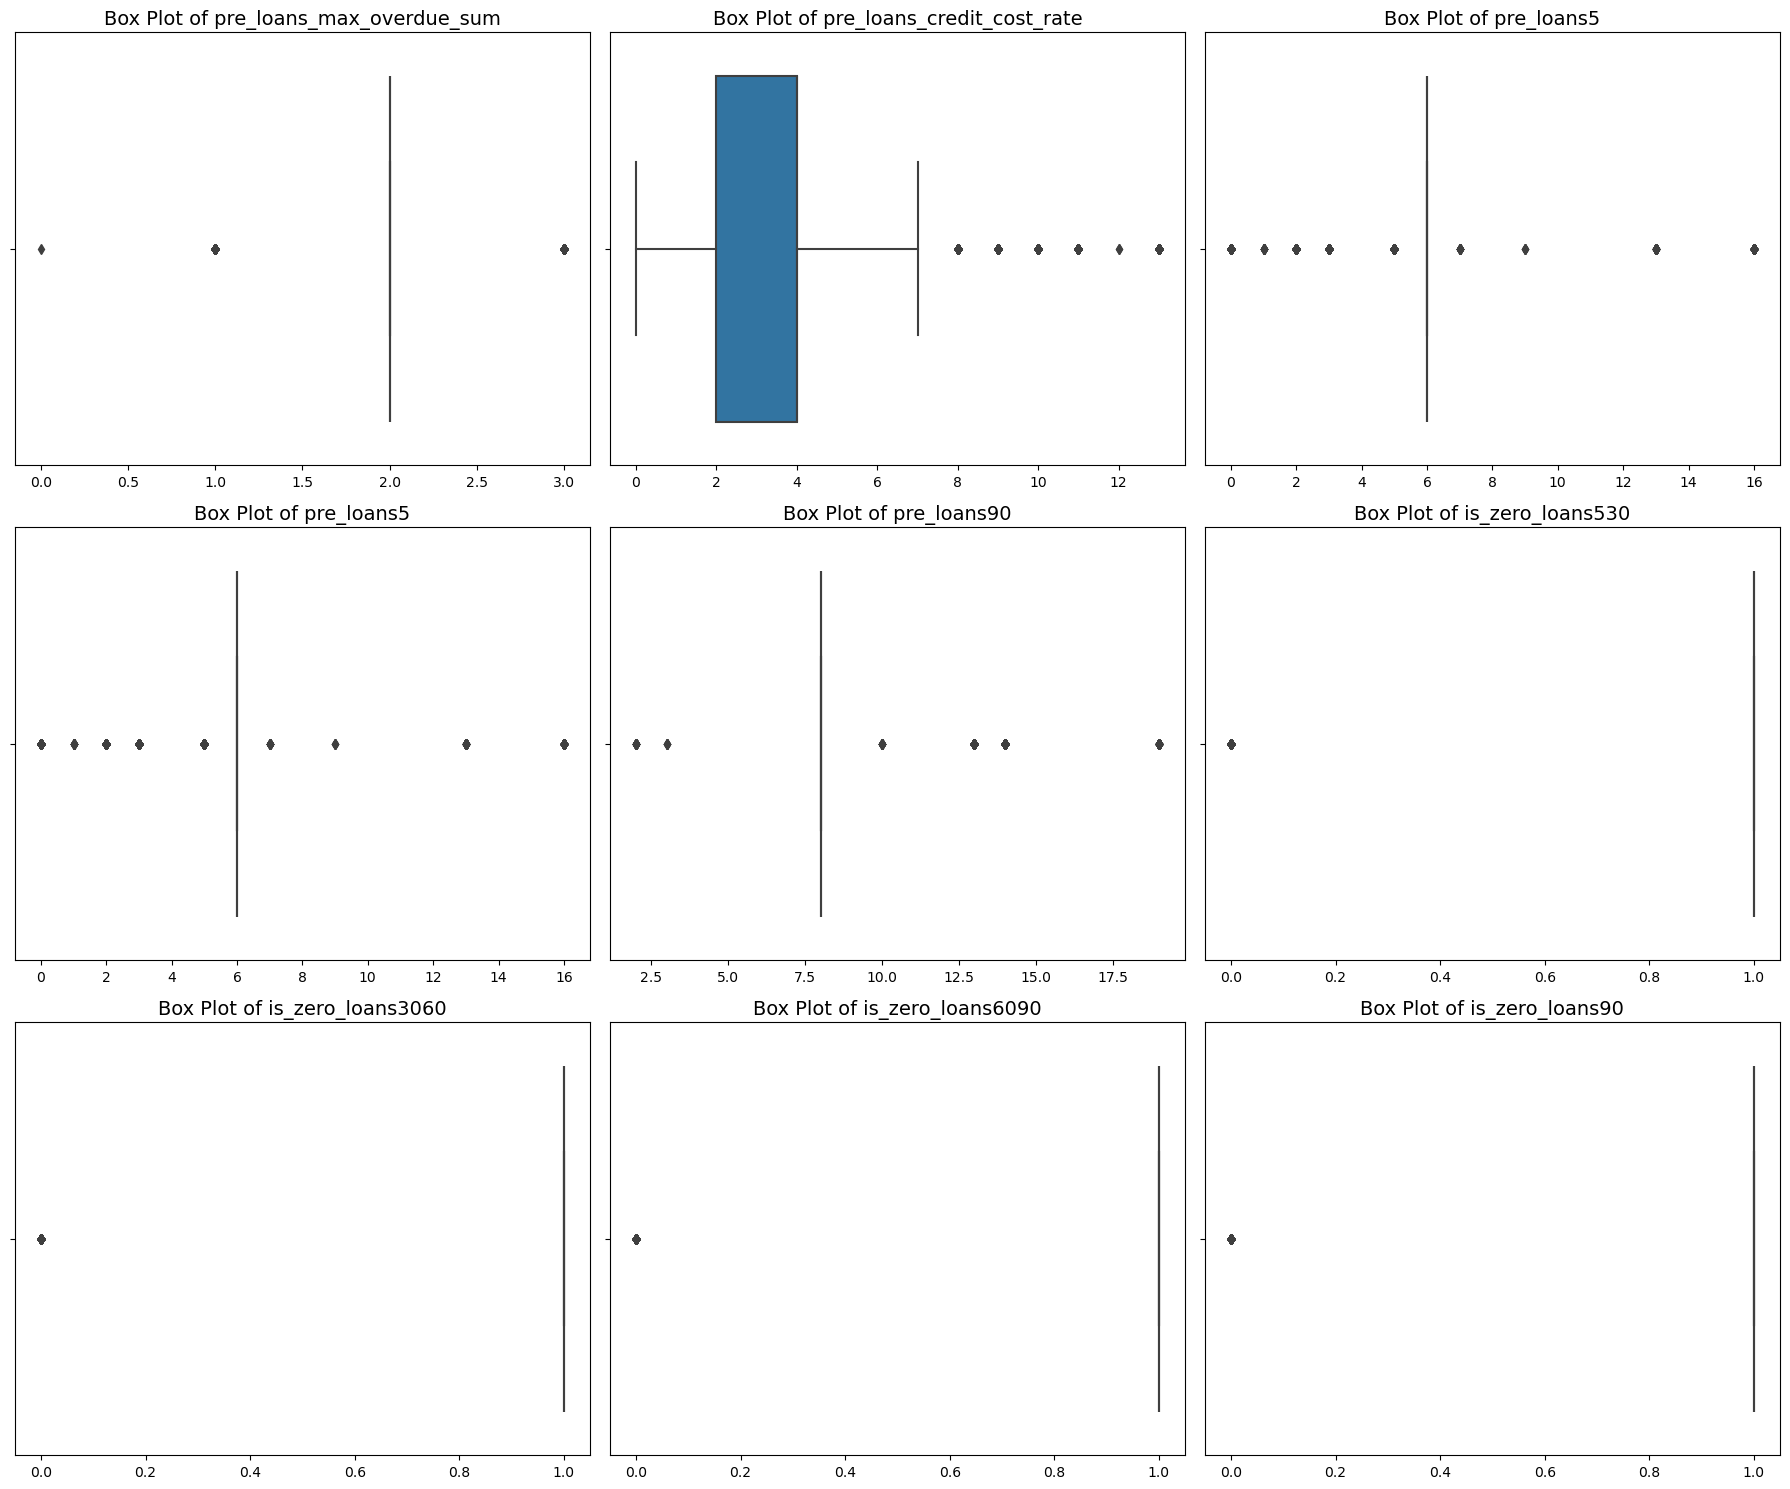

In [72]:
# Подробная визуализация признаков с выбросами:
features_with_outliers = ['pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 
                          'pre_loans5', 'pre_loans5',  'pre_loans90', 'is_zero_loans530',
                          'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']
n_cols = 3
n_rows = int(np.ceil(len(features_with_outliers) / n_cols))
plt.figure(figsize=(n_cols * 6, n_rows * 5))
for i, feature in enumerate(features_with_outliers):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=data[feature])
    plt.title(f'Box Plot of {feature}', fontsize=14)
    plt.xlabel('')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
plt.tight_layout()
plt.show()



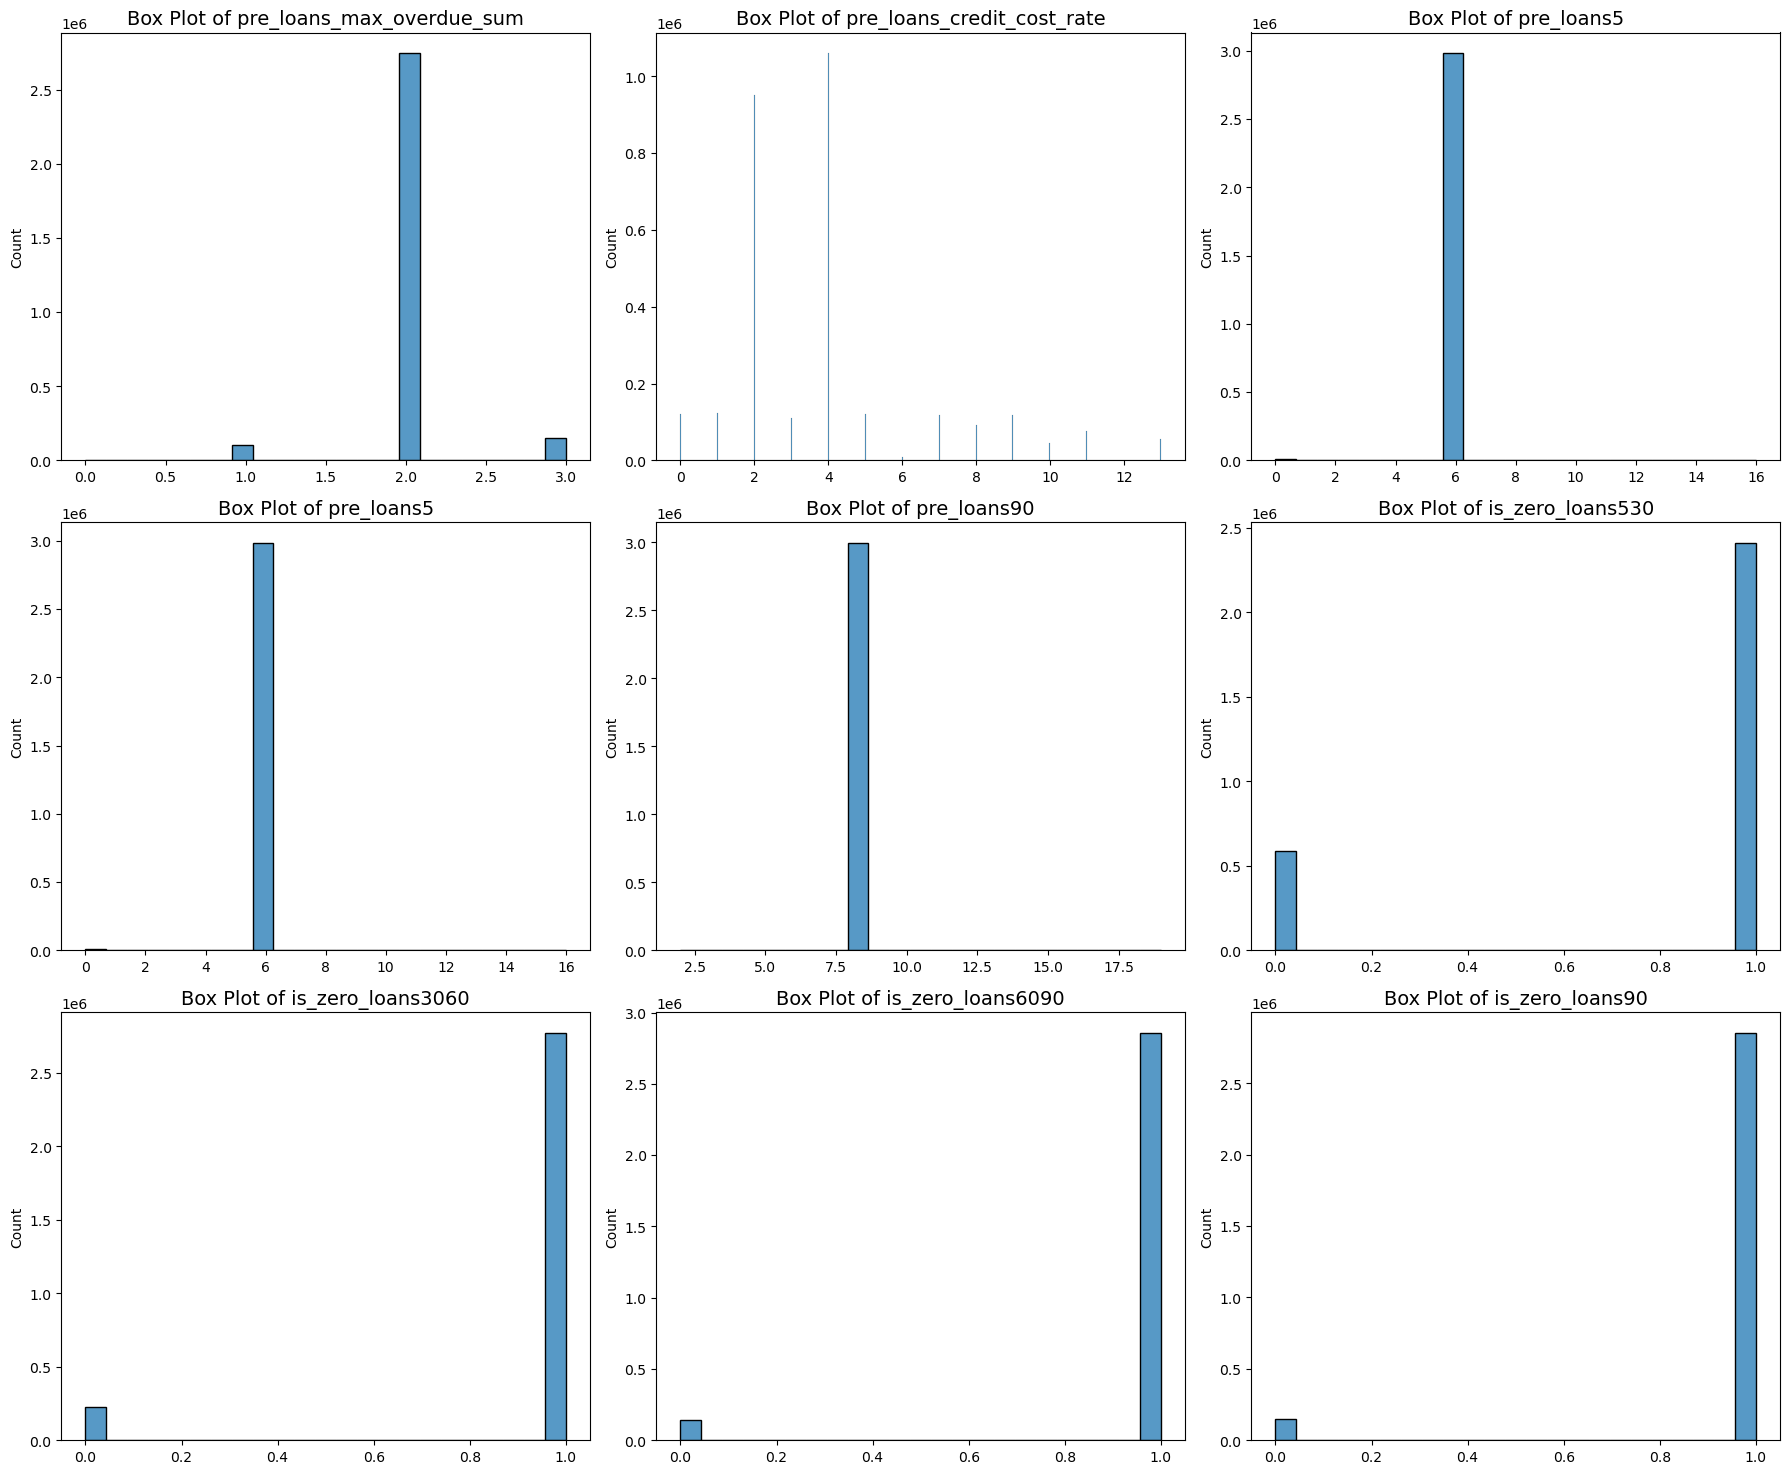

In [73]:
features_with_outliers = ['pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 
                          'pre_loans5', 'pre_loans5',  'pre_loans90', 'is_zero_loans530',
                          'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']
n_cols = 3
n_rows = int(np.ceil(len(features_with_outliers) / n_cols))
plt.figure(figsize=(n_cols * 6, n_rows * 5))
for i, feature in enumerate(features_with_outliers):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(x=data[feature])
    plt.title(f'Box Plot of {feature}', fontsize=14)
    plt.xlabel('')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    
plt.tight_layout()
plt.show()

 is_zero_loans_530 — флаг: нет просрочек от 5 до 30 дней.
 is_zero_loans_3060 — флаг: нет просрочек от 30 до 60 дней.
 is_zero_loans_6090 — флаг: нет просрочек от 60 до 90 дней.
 is_zero_loans90 — флаг: нет просрочек более чем на 90 дней
 Как можно заметить, у большинтсва людей нет просрочек, поэтому в boxplots 1- выходит за прделеы усов, что нельзя удалять и счтать за выбросы

In [14]:
from IPython.display import display, HTML
html_table = "<table>"
for column in data.columns:
    null_count = data[column].isnull().sum()
    if null_count > 0:
        html_table += f"<tr><td><b>{column}</b></td><td>{null_count}</td><td>пропущено</td></tr>"
    else:
        html_table += f"<tr><td><b>{column}</b></td><td>0</td><td>не имеет пропусков</td></tr>"
html_table += "</table>"

# Добавление статистических характеристик
html_table += data.describe(include='all').to_html()

# Отображение таблицы
display(HTML(html_table))

In [20]:
data_types_df = pd.DataFrame({'Столбец': data.columns, 'Тип данных': data.dtypes})

# Преобразование DataFrame в HTML
html_table = data_types_df.to_html(index=False)

# Отображение таблицы
display(HTML(html_table))

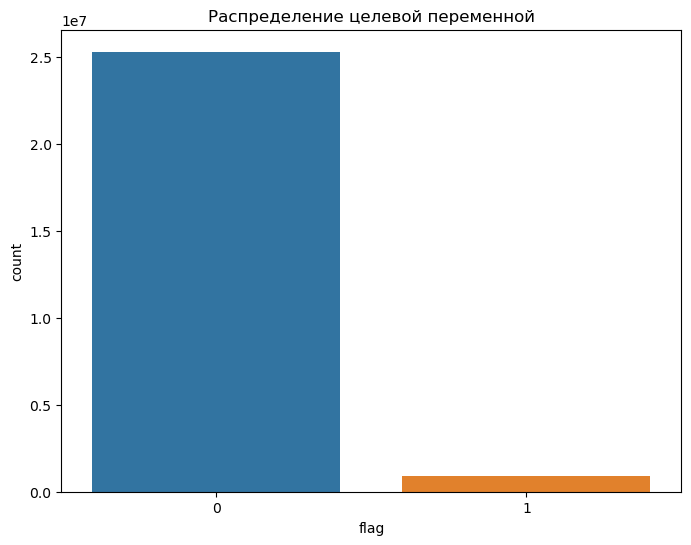

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(x='flag', data=data_merged)
plt.title('Распределение целевой переменной')
plt.show()

Можем наглядно заметить что данные сильно не сбалансированы

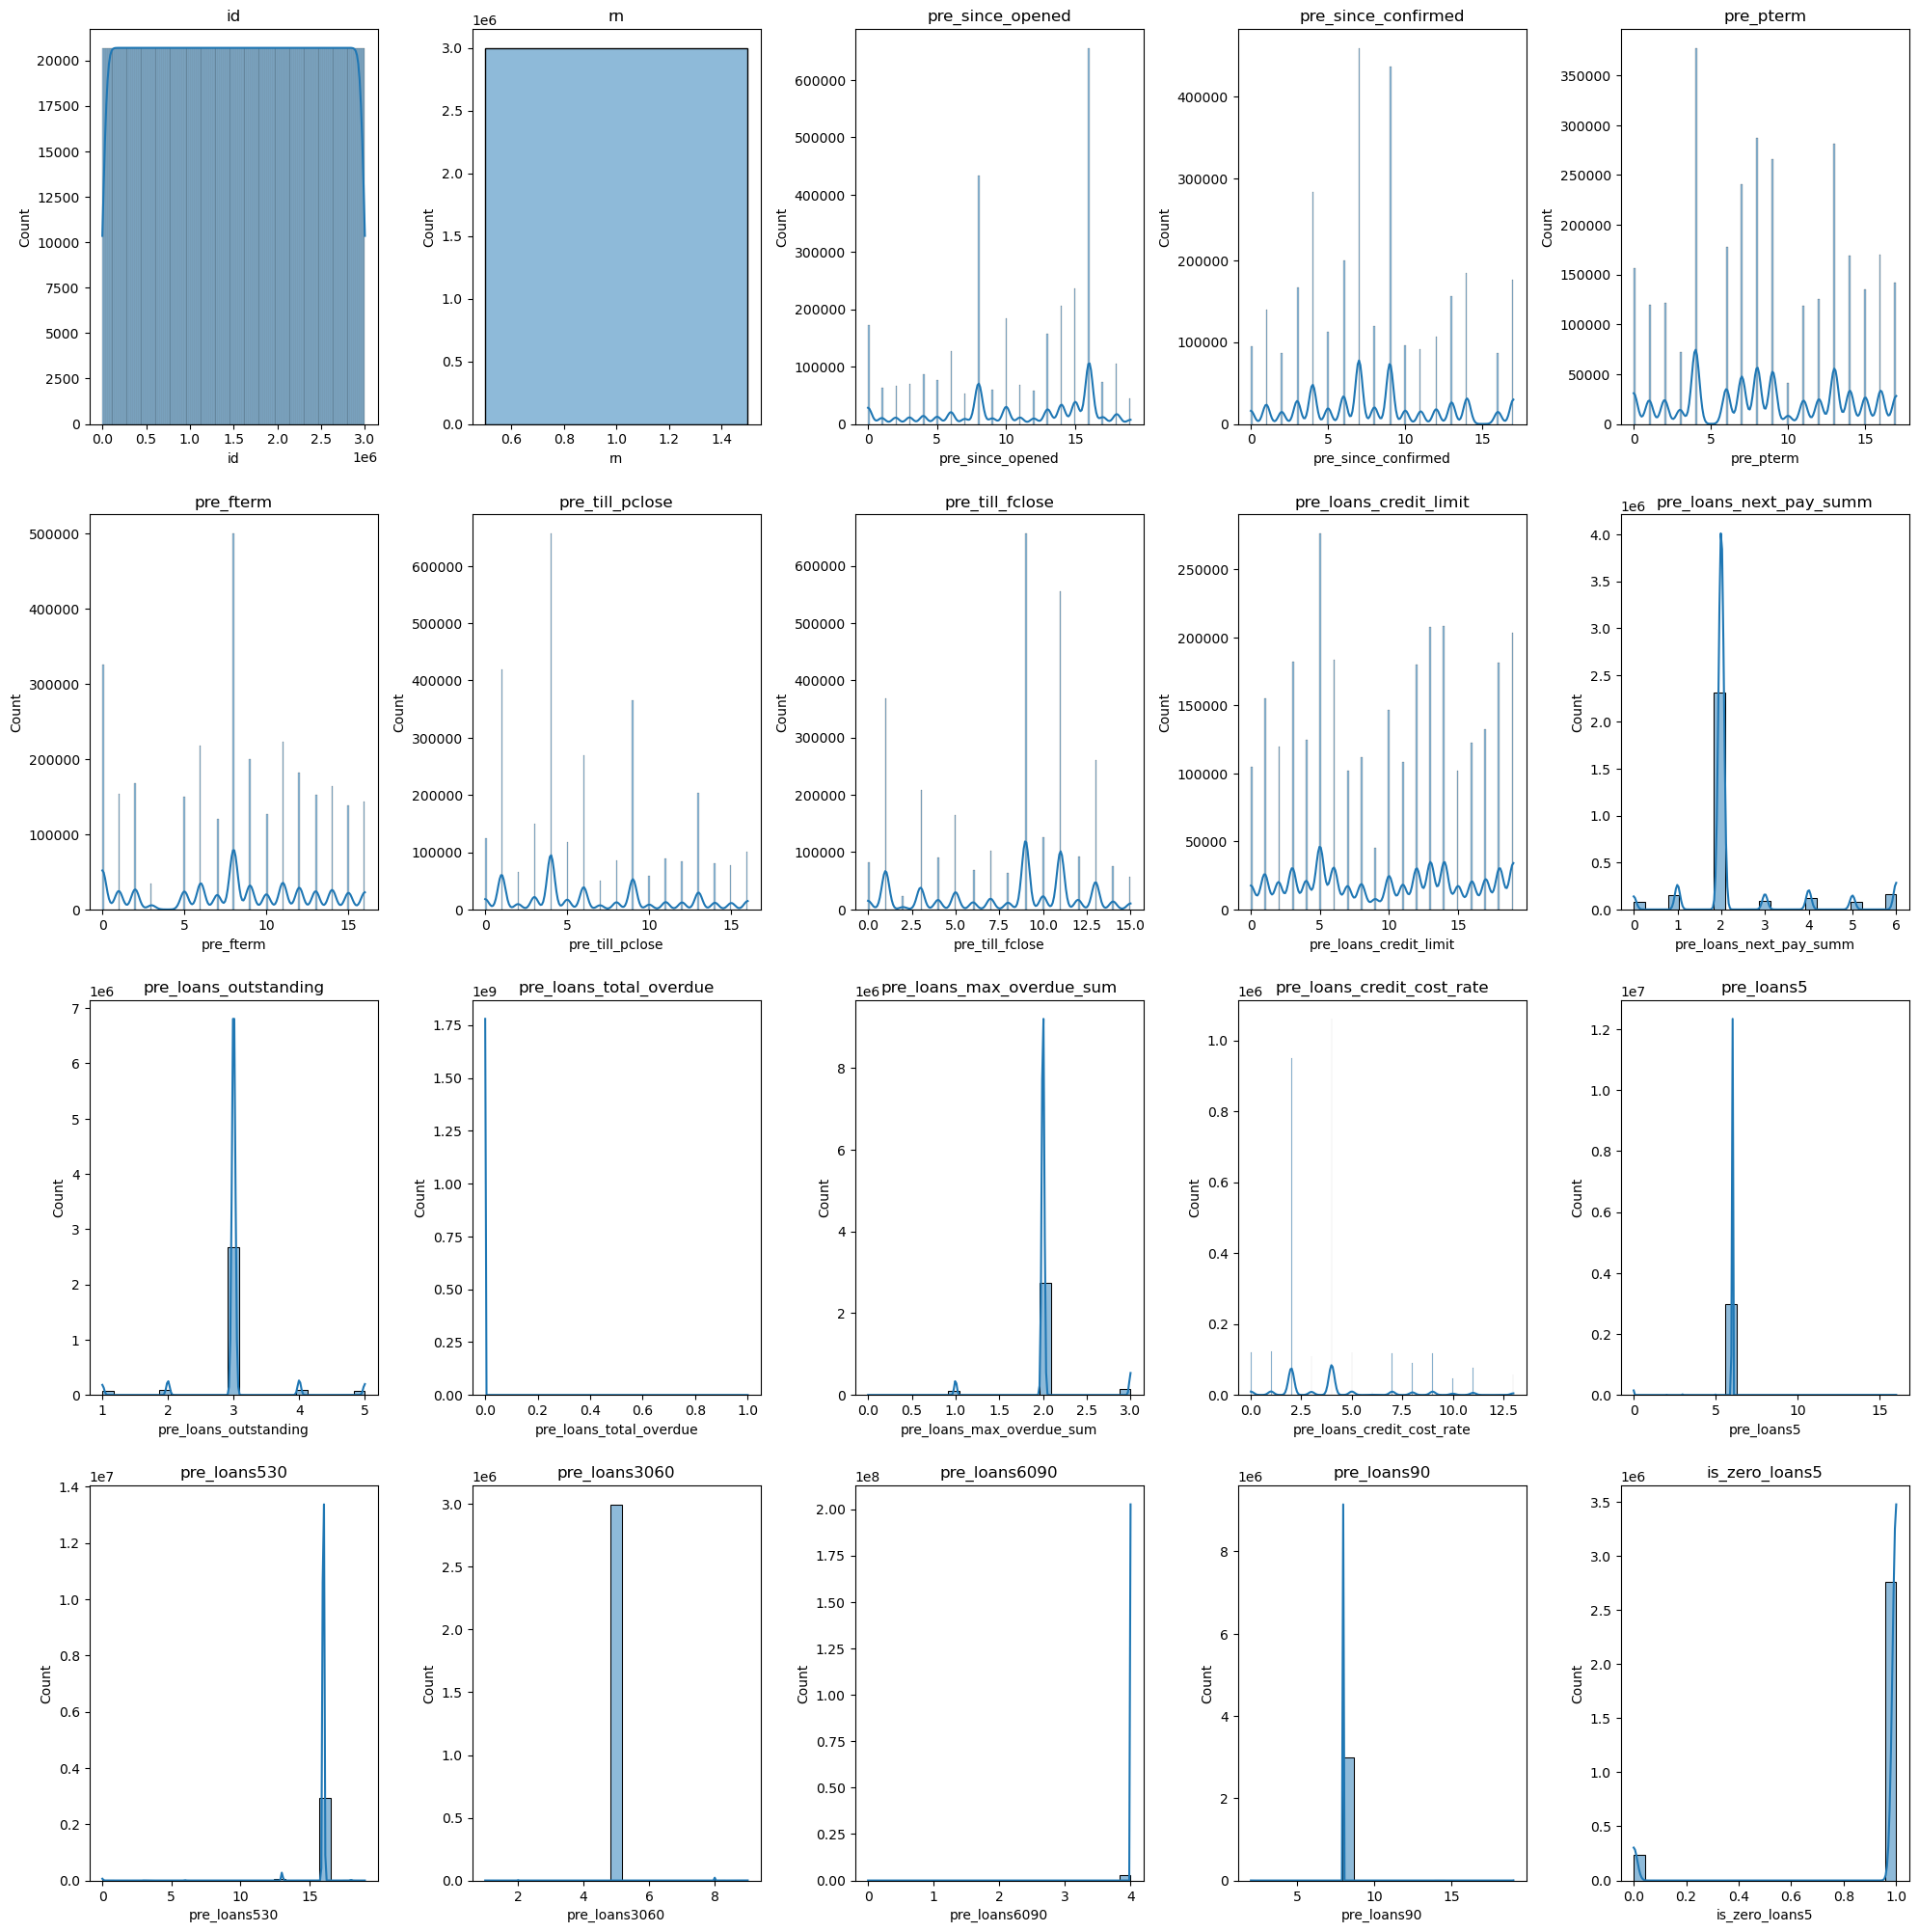

In [35]:
features = data_final.columns
cols = len(features)
rows = int(np.ceil(cols / 5))
plots = min(cols, 20)
plt.figure(figsize=(20, 5 * rows))
for i, col in enumerate(features, 1):
    plt.subplot(rows, 5, i)
    sns.histplot(data_final[col], kde=True)
    plt.title(col)
    if i == plots:
        break
plt.tight_layout()
plt.show()

In [40]:
num_features = [col for col in data_final.columns if data_final[col].dtype in ['int64', 'float64'] and col not in ['id', 'rn', 'flag']]

# Количество значений целевой переменной
target_classes = data_final['flag'].nunique()

plt.figure(figsize=(25, 5 * len(num_features)))

for i, col in enumerate(num_features):
    plt.subplot((len(num_features) + 1) // 2, 2, i + 1)
    sns.histplot(data=data_final, x=col, hue='flag', multiple='stack', kde=True)
    plt.title(f'Distribution of {col} by flag')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout(pad=3.0)  # Увеличиваем отступы между графиками
plt.show()

Многие признаки имеют сильно скошенные распределения, что может указывать на редкие, но важные значения (например, признаки pre_loans_credit_limit, pre_loans_next_pay_summ, pre_loans_outstanding и другие).
Признаки pre_since_opened, pre_since_confirmed, pre_pterm, pre_till_pclose, pre_till_fcclose и другие имеют более равномерное распределение, но с отчетливыми пиками, что может указывать на определенные временные рамки или пороги, которые имеют большое значение для модели.
Признаки, связанные с кредитами, такие как pre_loans_total_overdue, pre_loans_max_overdue_sum, pre_loans_credit_cost_rate и другие, показывают значительные пики на низких значениях, что может указывать на то, что большинство клиентов не имеют серьезных просрочек или задолженностей.
Некоторые признаки показывают значительные значения только для небольшого числа записей, что может указывать на аномалии или редкие события, которые могут быть важны для модели. Например, признаки pre_loans530, pre_loans3060, pre_loans6090, pre_loans90 и другие имеют высокие значения только для нескольких записей.